<a href="https://colab.research.google.com/github/zhoulvwen/Lantern/blob/master/Creating_Economic_Indicators_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate Risk Score Function Example

In [ ]:
import numpy as np

# Goal: Calculate a risk-assessment score for tariffs based on economic indicators
def calc_risk_score(gdp_growth, inflation, wages, industrial_production, manufacturing_demand):

    # Define weights for each factor based on economic impact
    weights = {
        'gdp_growth': -0.4,  # Negative weight: higher GDP growth reduces risk
        'inflation': 0.3,     # Higher inflation increases risk
        'wages': -0.2,        # Higher wages reduce risk
        'industrial_production': -0.3,  # Increased production lowers risk
        'manufacturing_demand': -0.3    # Higher demand lowers risk
    }

    # Normalize inputs using a simple transformation to keep values in comparable ranges
    gdp_norm = np.clip(gdp_growth / 5, -1, 1)
    inflation_norm = np.clip(inflation / 5, -1, 1)
    wages_norm = np.clip(wages / 5, -1, 1)
    industrial_norm = np.clip(industrial_production / 5, -1, 1)
    demand_norm = np.clip(manufacturing_demand / 5, -1, 1)

    # Compute risk score as a linear combination of factors
    risk_score = (
        weights['gdp_growth'] * gdp_norm +
        weights['inflation'] * inflation_norm +
        weights['wages'] * wages_norm +
        weights['industrial_production'] * industrial_norm +
        weights['manufacturing_demand'] * demand_norm
    )

    # Scale risk score to 0-100
    risk_score_scaled = np.clip((risk_score + 1) * 50, 0, 100)

    return risk_score_scaled

# Test: hypothetical percentage changes
gdp_growth = 2.5
inflation = 3.0
wages = 1.5
industrial_production = -0.5
manufacturing_demand = 2.0

risk_score = calc_risk_score(gdp_growth, inflation, wages, industrial_production, manufacturing_demand)
print(f"Risk Score: {risk_score:.2f}")


Risk Score: 41.50


## Use PCA to Determine Weights

### Set-Up + Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv("economic_indicators_dataset_2010_2023.csv")

# Select relevant numerical columns (modify based on your actual column names)
features = ["Inflation Rate (%)", "GDP Growth Rate (%)", "Unemployment Rate (%)",
            "Interest Rate (%)", "Stock Index Value"]

# Drop any missing values (optional)
df = df.dropna(subset=features)

# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

### EDA

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   500 non-null    datetime64[ns]
 1   Country                500 non-null    object        
 2   Inflation Rate (%)     500 non-null    float64       
 3   GDP Growth Rate (%)    500 non-null    float64       
 4   Unemployment Rate (%)  500 non-null    float64       
 5   Interest Rate (%)      500 non-null    float64       
 6   Stock Index Value      500 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 27.5+ KB
None

Summary Statistics:
                                Date  Inflation Rate (%)  GDP Growth Rate (%)  \
count                            500           500.00000           500.000000   
mean   2017-03-21 19:26:24.000000256             5.08514             2.414780   
min       

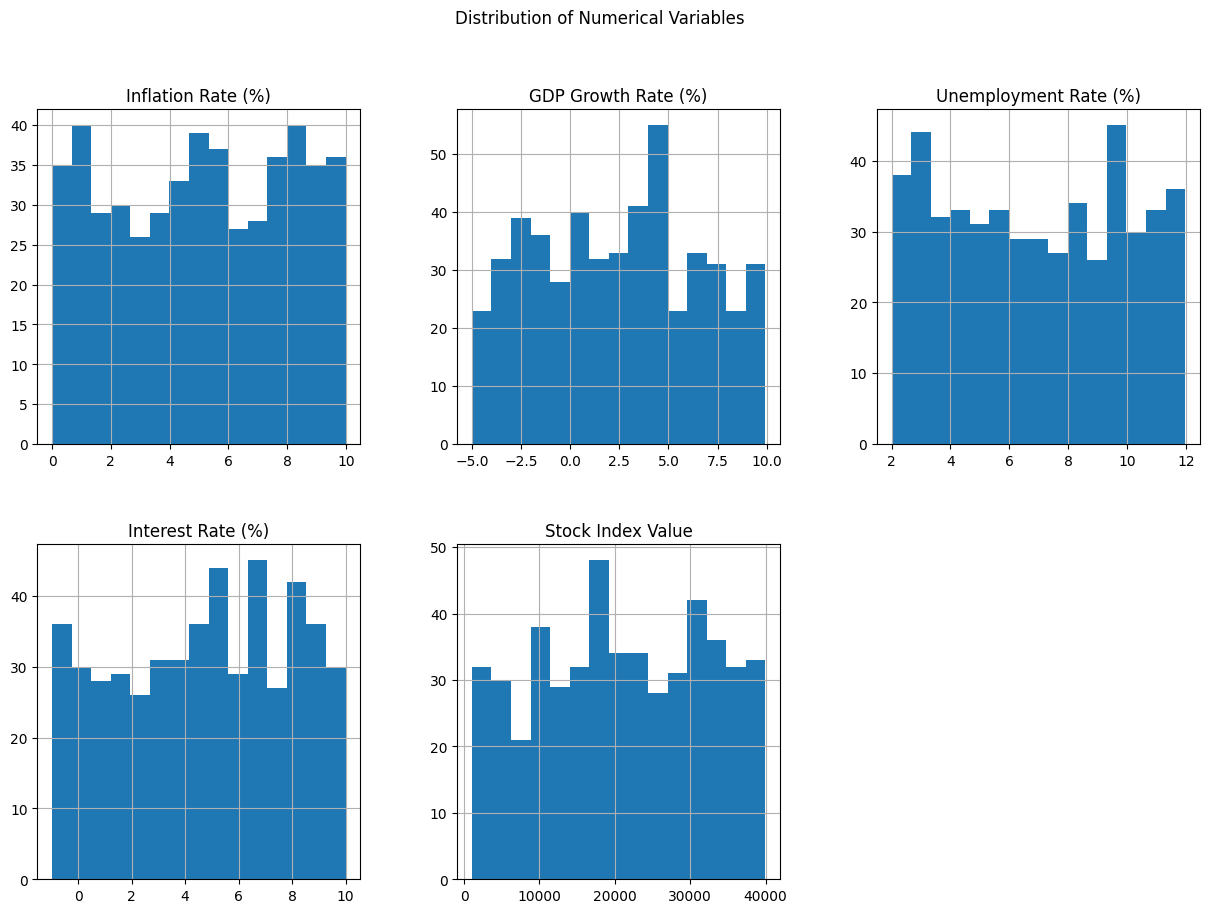

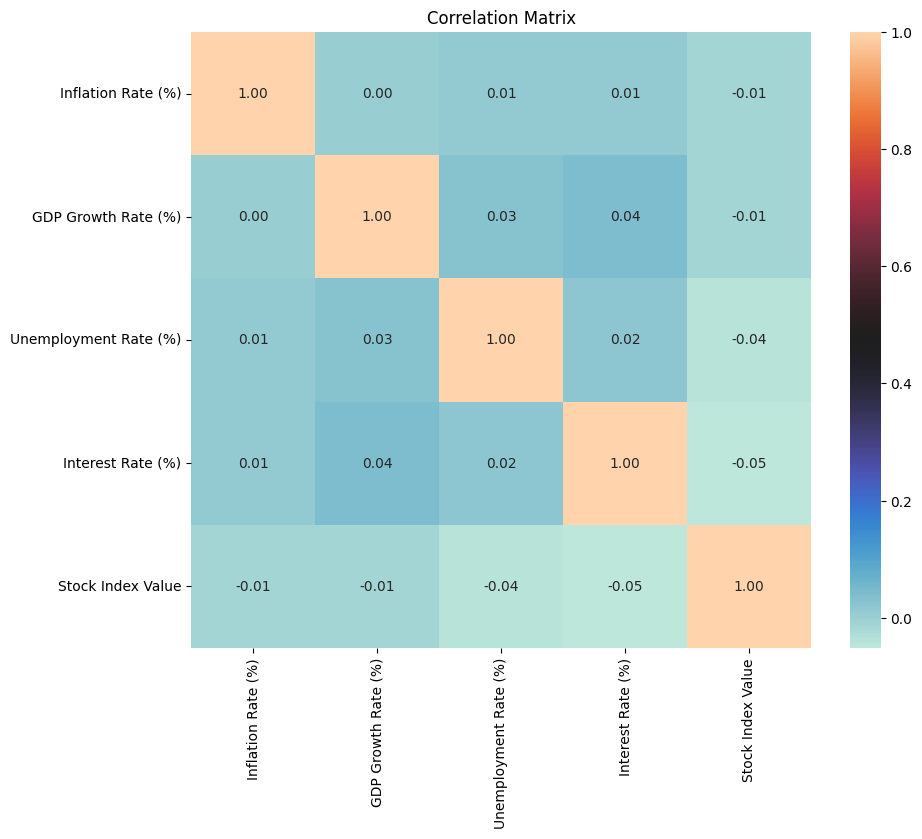

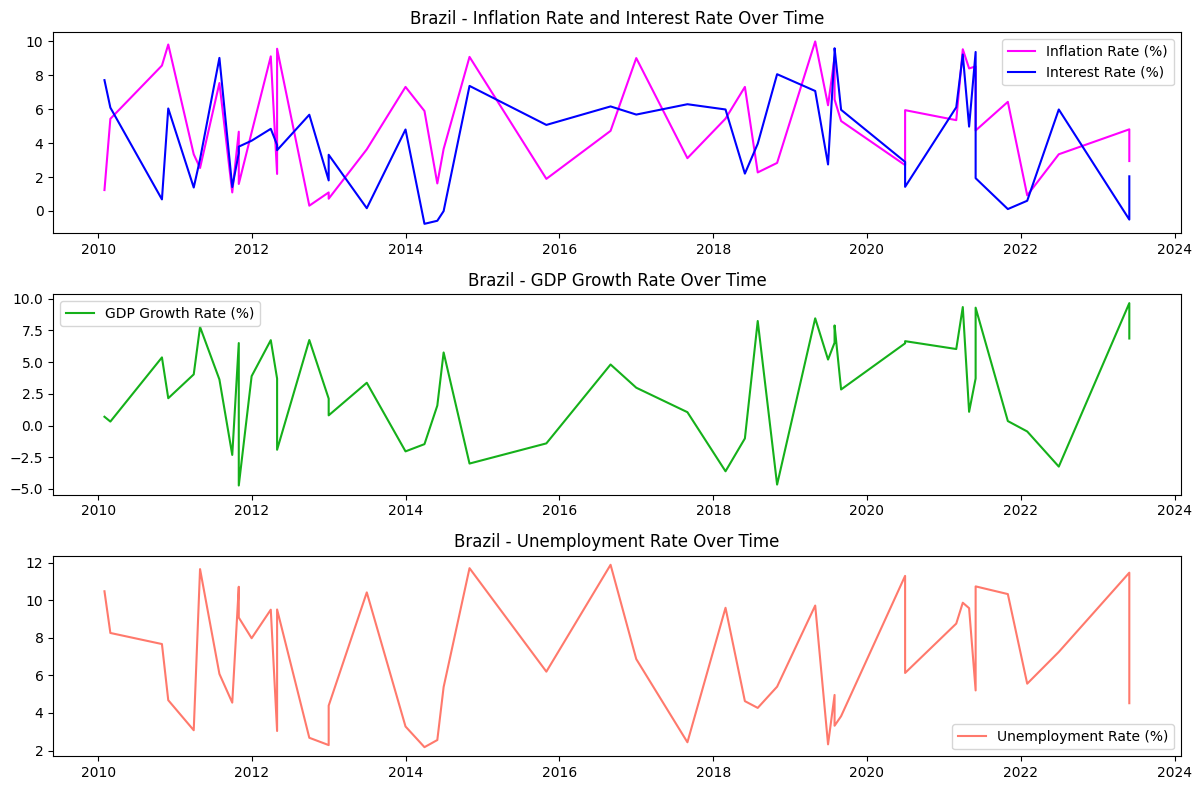

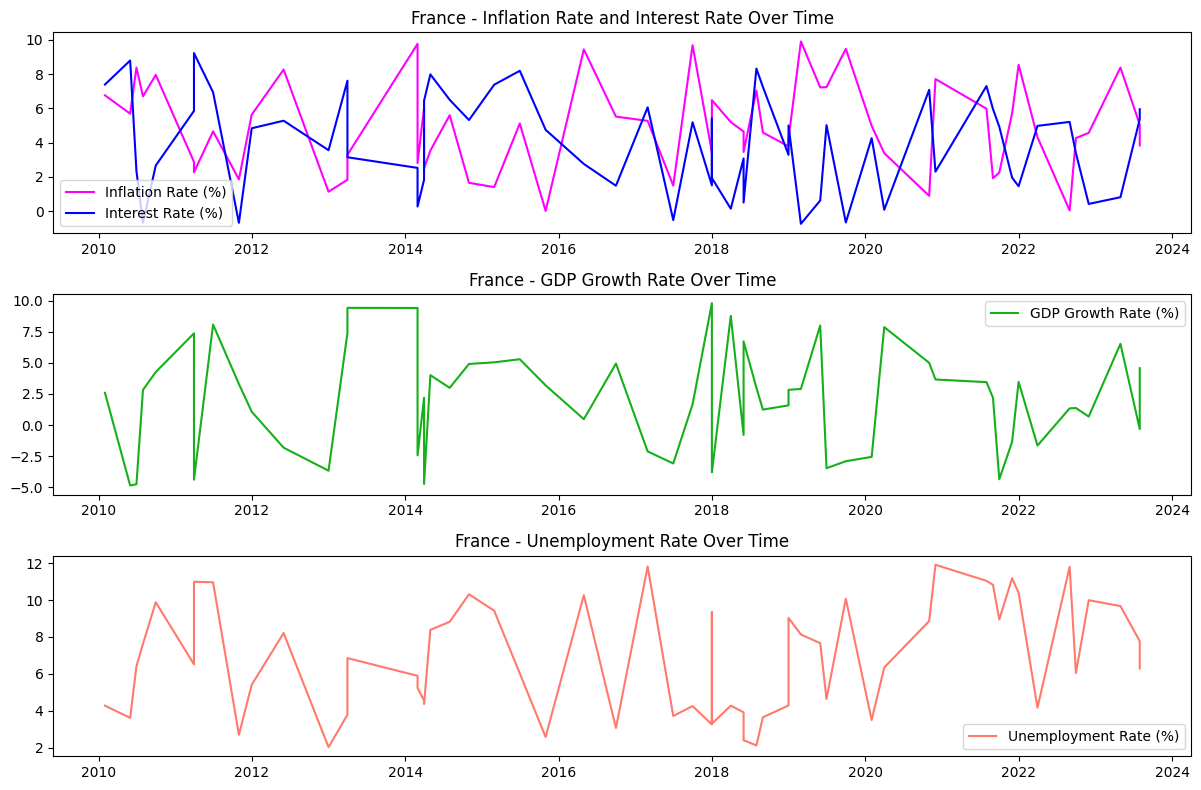

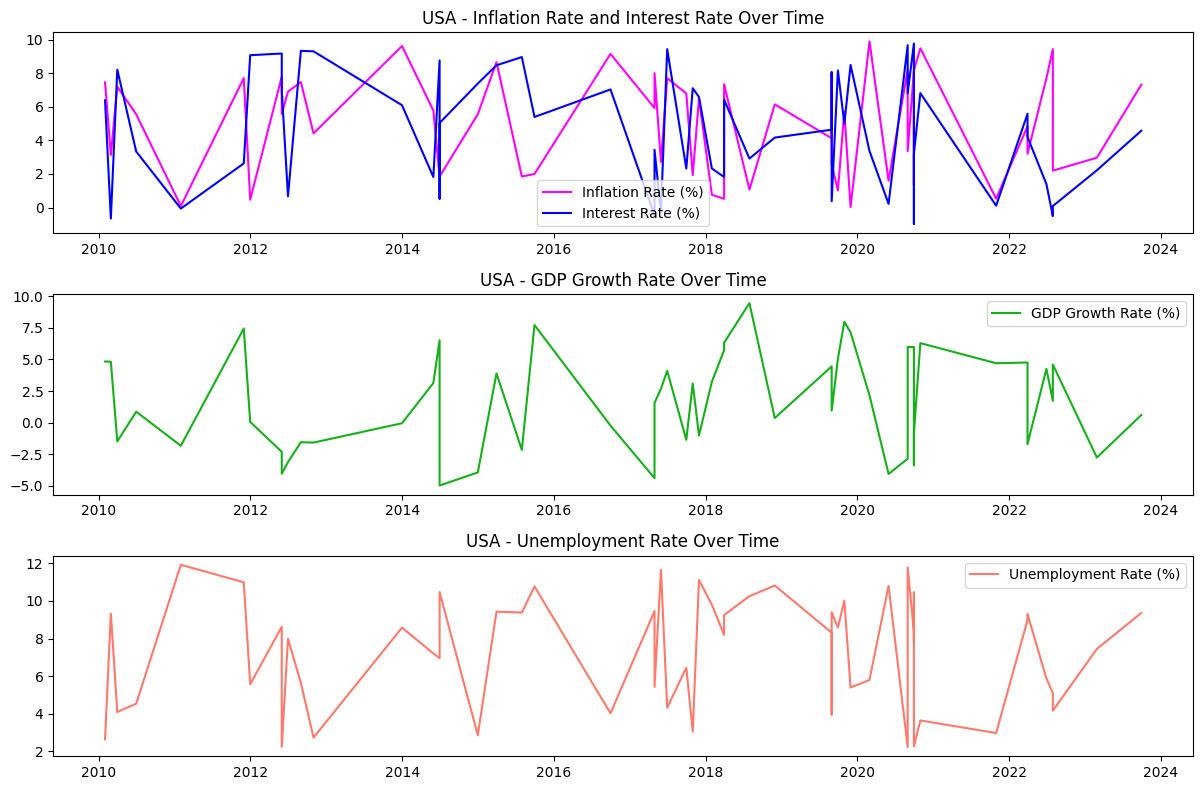

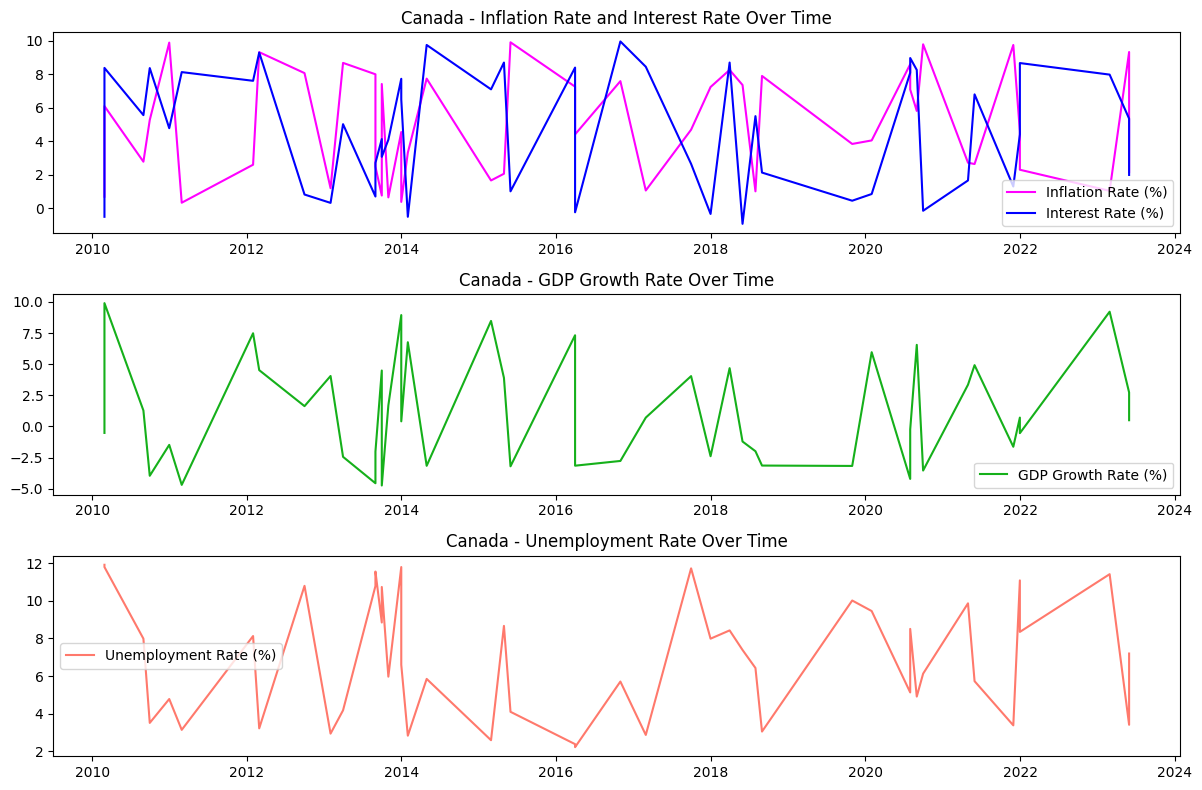

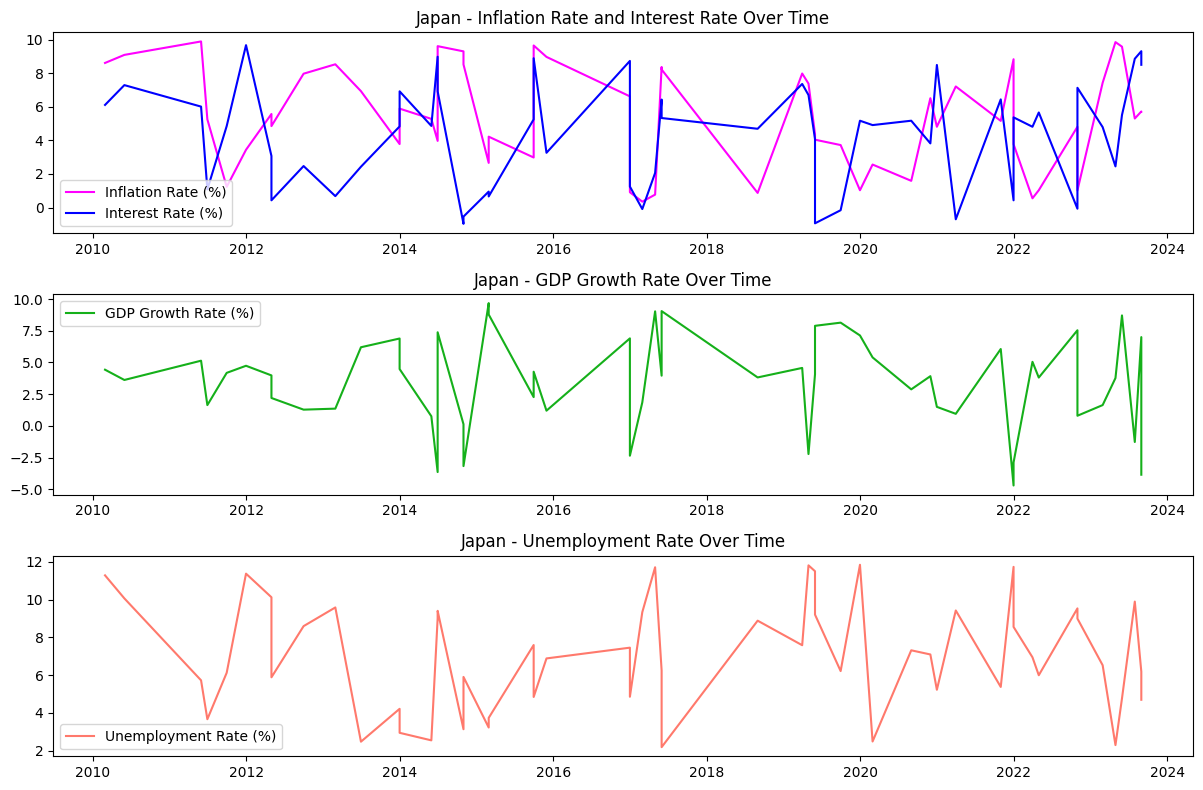

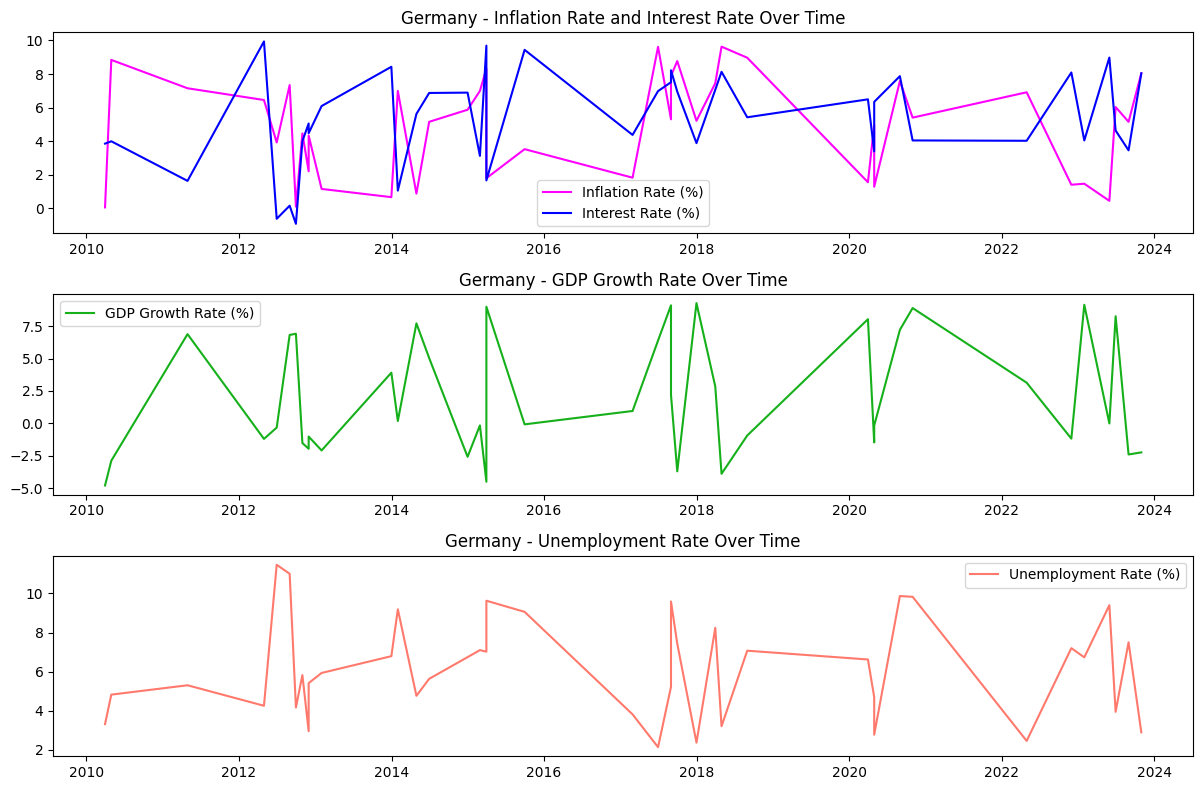

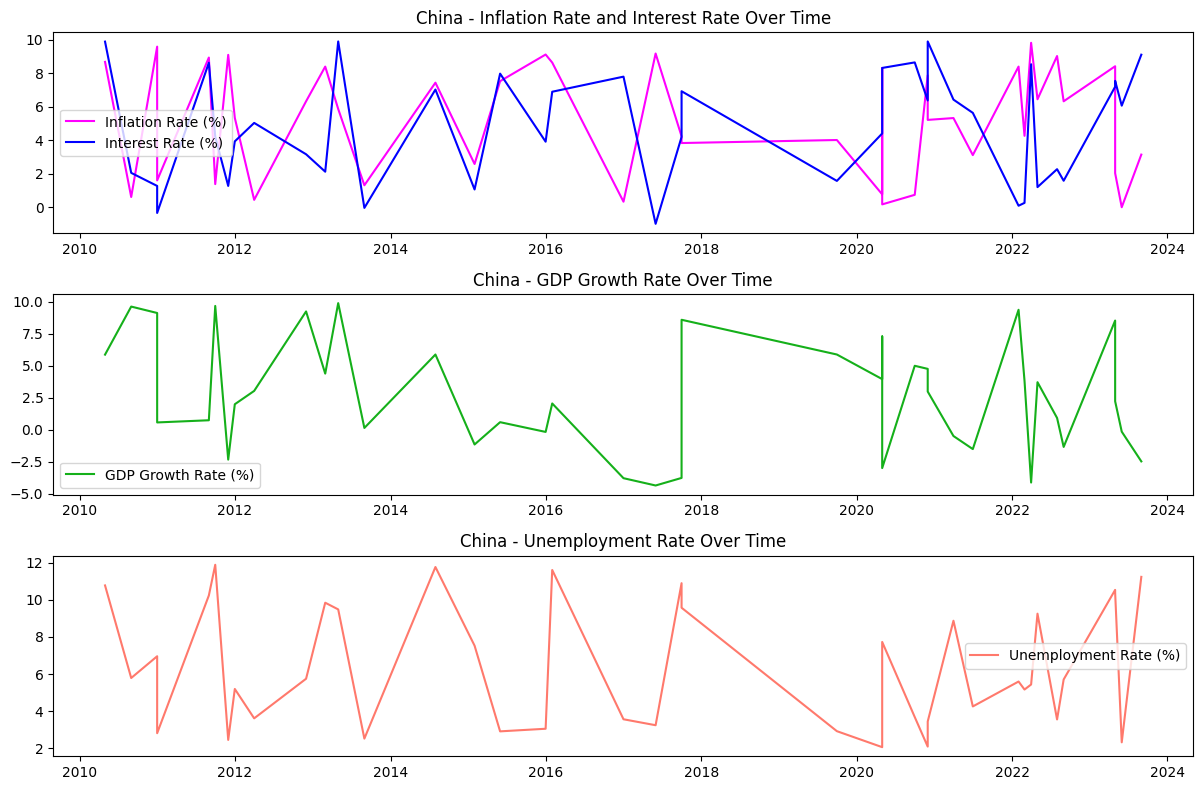

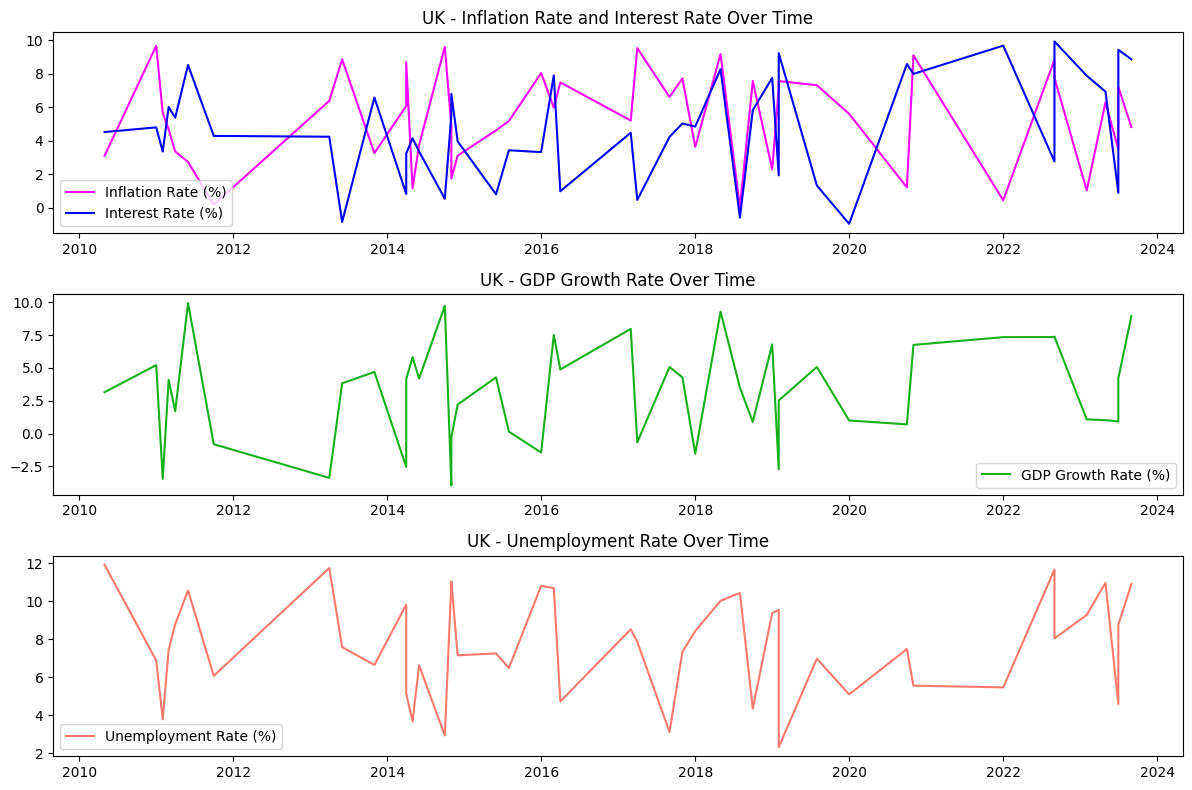

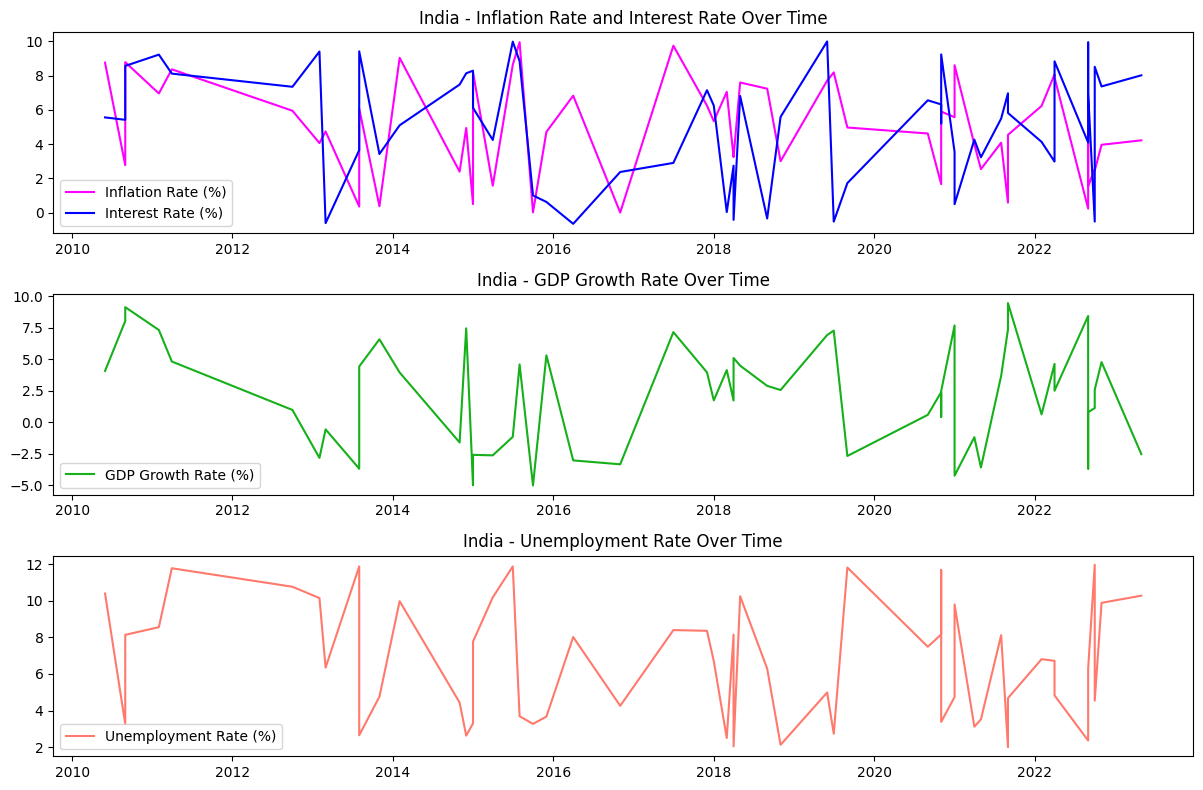

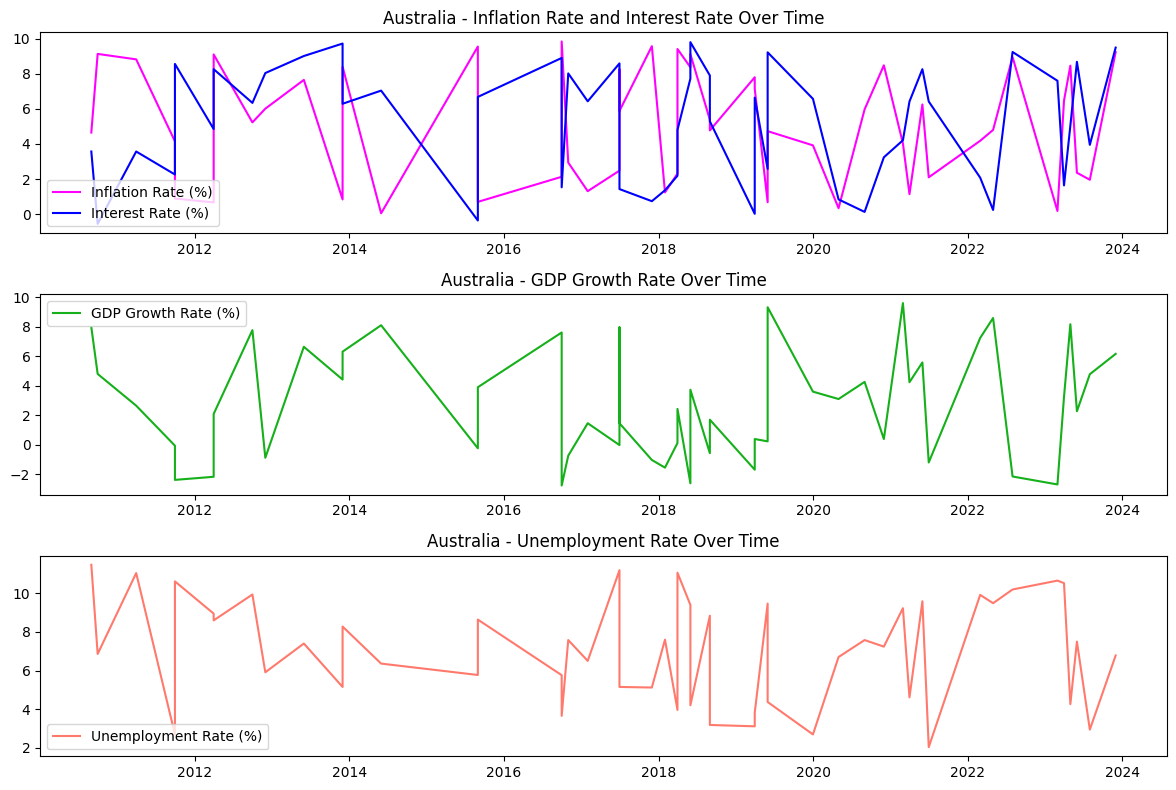

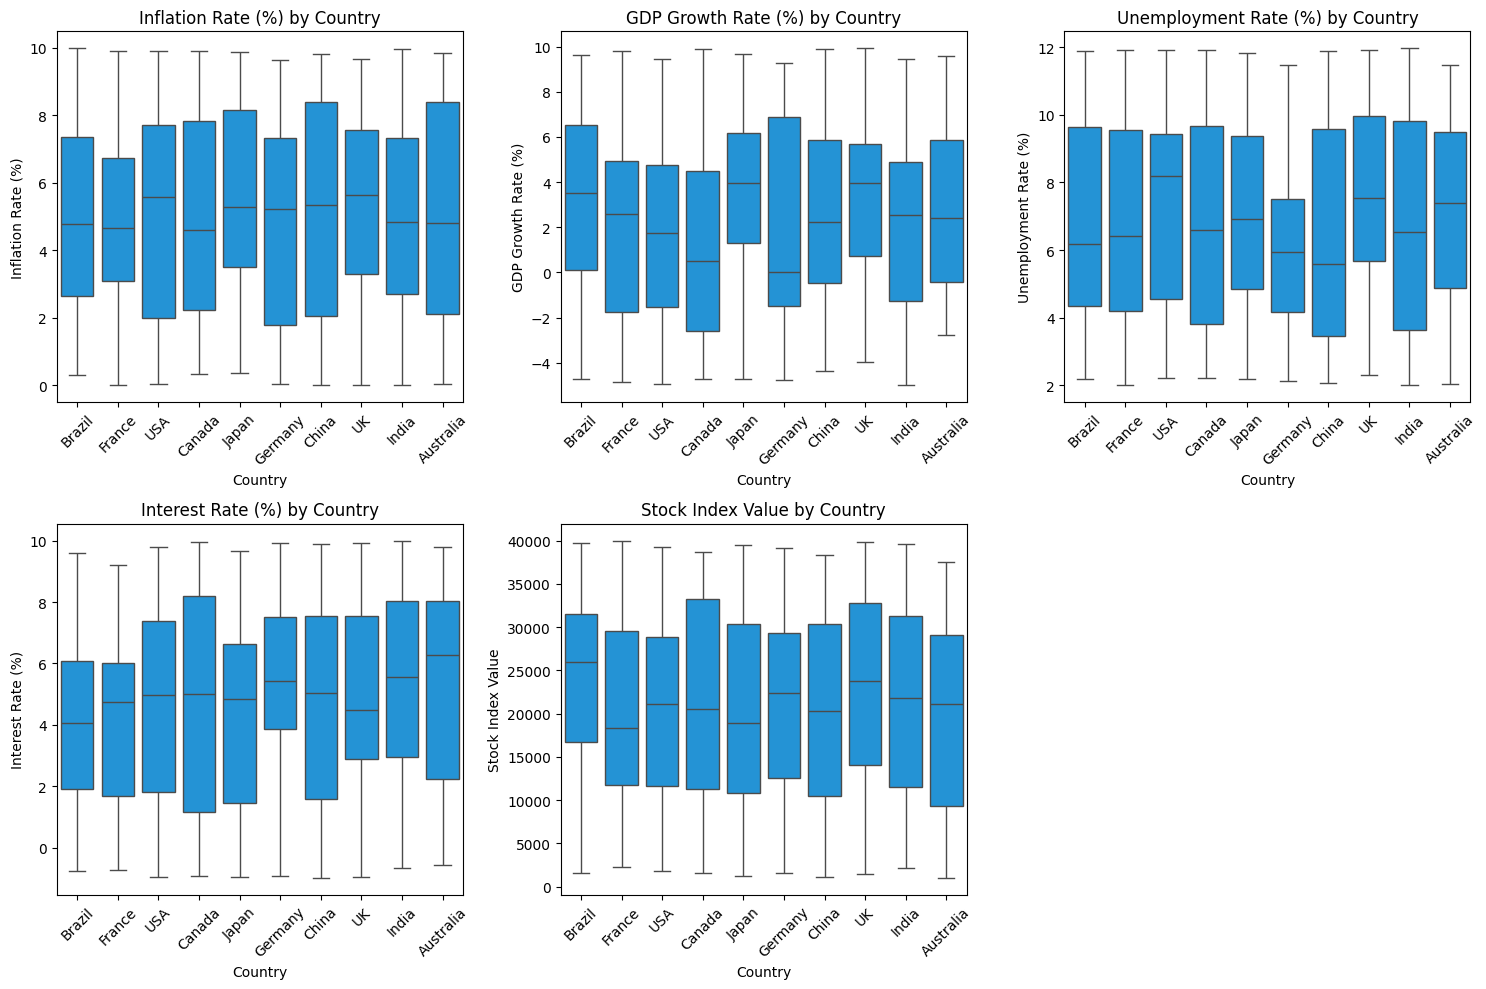

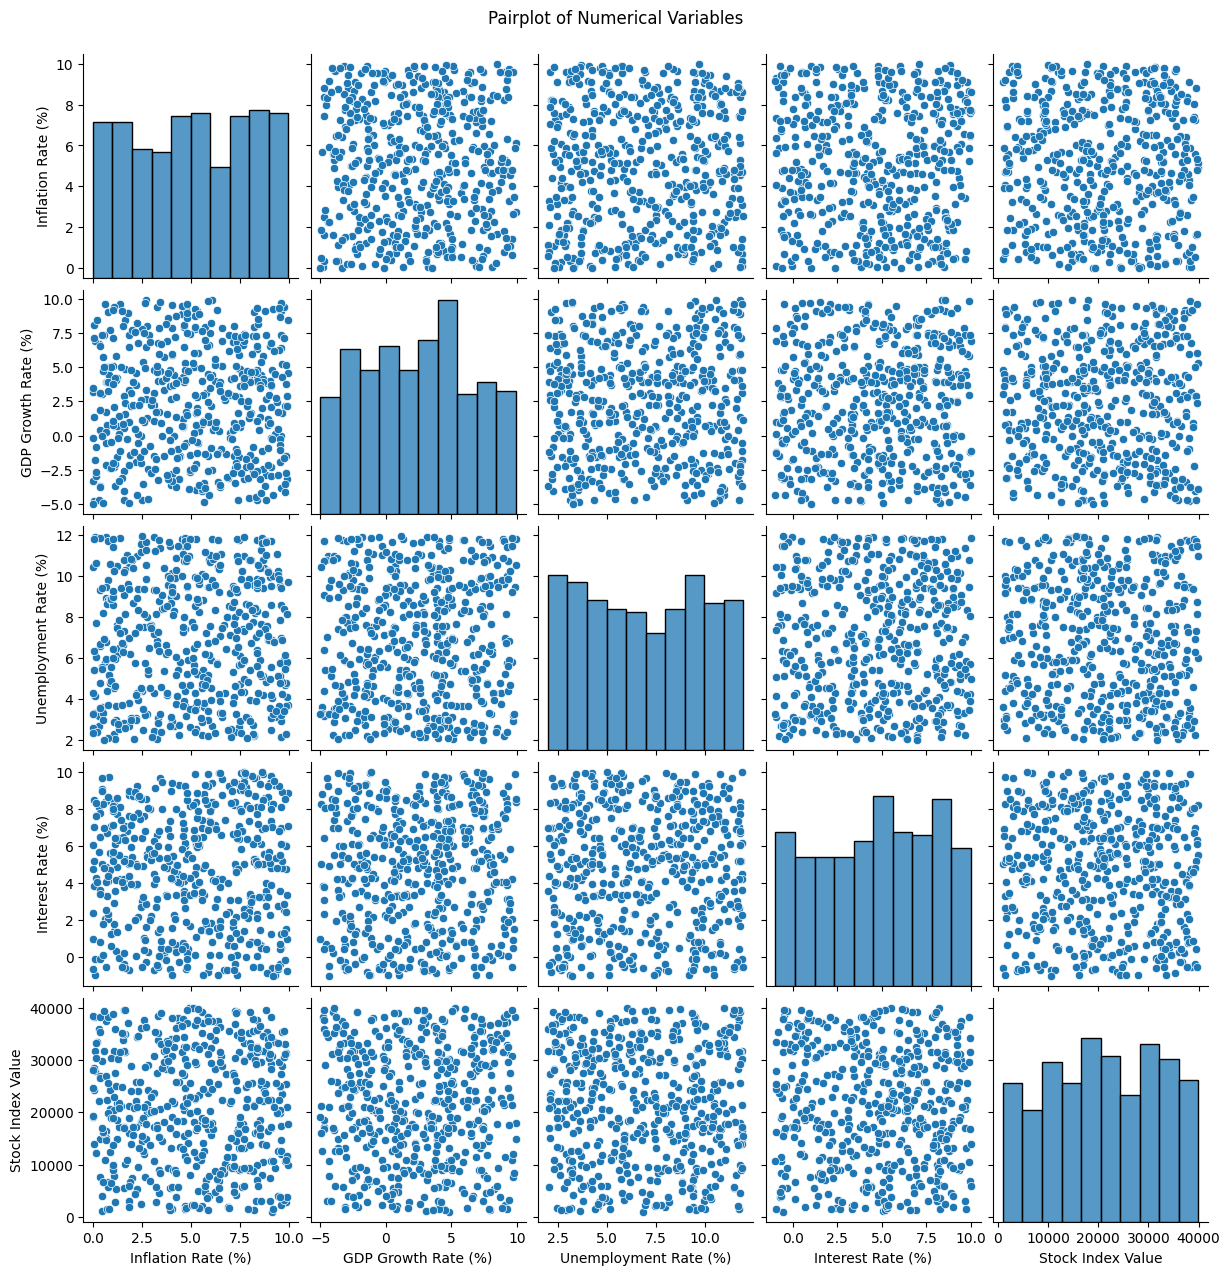

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize the distribution of numerical variables
numerical_columns = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value']
df[numerical_columns].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='icefire', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Time series analysis per country
countries = df['Country'].unique()
for country in countries:
    country_data = df[df['Country'] == country]
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(country_data['Date'], country_data['Inflation Rate (%)'], label='Inflation Rate (%)', color = 'magenta')
    plt.plot(country_data['Date'], country_data['Interest Rate (%)'], label='Interest Rate (%)', color = 'blue')
    plt.title(f'{country} - Inflation Rate and Interest Rate Over Time')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(country_data['Date'], country_data['GDP Growth Rate (%)'], label='GDP Growth Rate (%)', color = '#15B01A')
    plt.title(f'{country} - GDP Growth Rate Over Time')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(country_data['Date'], country_data['Unemployment Rate (%)'], label='Unemployment Rate (%)', color = '#FF796C')
    plt.title(f'{country} - Unemployment Rate Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Boxplots to compare distributions across countries
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Country', y=column, data=df, color = '#069AF3')
    plt.title(f'{column} by Country')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Create a GIF to illustrate US/China GDP

Duplicate entries found. Aggregating data by taking the mean.
GIF saved as 'us_china_gdp_growth.gif'


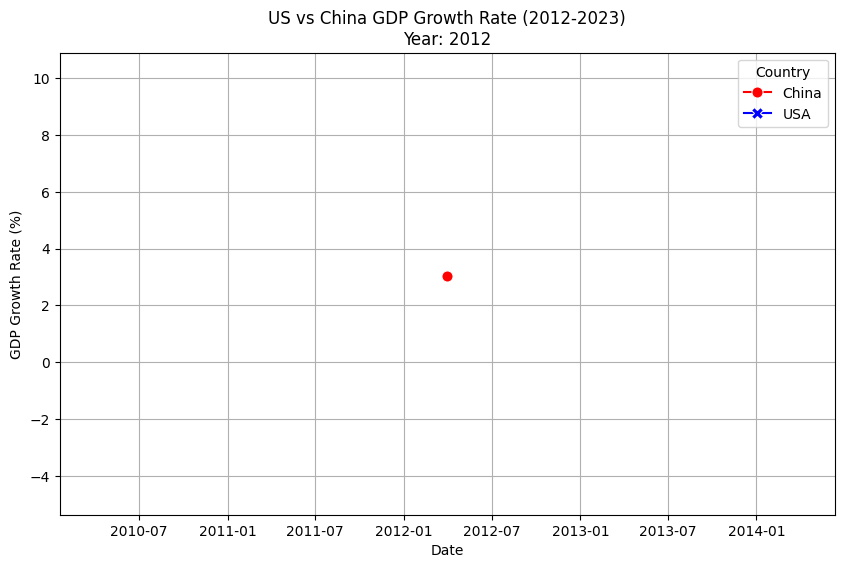

In [ ]:
import matplotlib.animation as animation

# Create a copy of the dataframe so I don't mess anything up
df_copy = df.copy()

# Filter data for 2016 to 2023
df_copy = df_copy[(df_copy['Date'].dt.year >= 2012) & (df_copy['Date'].dt.year <= 2023)]

# Filter data for US and China
df_copy = df_copy[df_copy['Country'].isin(['USA', 'China'])]

# Duplicates
duplicates = df_copy.duplicated(subset=['Date', 'Country'], keep=False)
# Debug: Why is this aggregating when printed no duplicates?
if duplicates.any():
    print("Duplicate entries found. Aggregating data by taking the mean.")
    df_copy = df_copy.groupby(['Date', 'Country'], as_index=False).mean()

# Pivotttttt!!!!
df_pivot = df_copy.pivot(index='Date', columns='Country', values='GDP Growth Rate (%)')

# Create a function to update plot for each frame
def update(frame):
    plt.clf()  # Clear previous frame
    sns.lineplot(data=df_pivot.iloc[:frame+1], dashes=False, markers=True, markersize=8, palette={'China': 'red', 'USA': 'blue'})
    plt.title(f'US vs China GDP Growth Rate (2012-2023)\nYear: {df_pivot.index[frame].year}')
    plt.xlabel('Date')
    plt.ylabel('GDP Growth Rate (%)')
    plt.ylim(df_pivot.min().min() - 1, df_pivot.max().max() + 1)  # y-axis limits
    plt.legend(title='Country')
    plt.grid(True)

# Animation
fig = plt.figure(figsize=(10, 6))
ani = animation.FuncAnimation(fig, update, frames=len(df_pivot), interval=500, repeat=False)

# Save animation as a GIF
ani.save('us_china_gdp_growth.gif', writer='pillow')

print("GIF saved: 'us_china_gdp_growth.gif'")

### PCA

In [ ]:
# PCA
pca = PCA(n_components=len(features))  # Keep all components?
# Note: need to revist
pca.fit(scaled_data)

# Explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Feature loadings
pca_components = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(len(features))])

# Results
print("Explained Variance Ratio per Principal Component:")
print(explained_variance)
print("\nPrincipal Component Loadings:")
print(pca_components)


Explained Variance Ratio per Principal Component:
[0.22091713 0.19941054 0.19731069 0.19596341 0.18639823]

Principal Component Loadings:
     Inflation Rate (%)  GDP Growth Rate (%)  Unemployment Rate (%)  \
PC1            0.208176             0.416319               0.465856   
PC2            0.905309            -0.404262               0.016612   
PC3            0.363332             0.694812              -0.216457   
PC4           -0.007696             0.153091               0.764846   
PC5           -0.070769            -0.396295               0.388406   

     Interest Rate (%)  Stock Index Value  
PC1           0.537044          -0.527165  
PC2          -0.113210          -0.062406  
PC3           0.074587           0.576896  
PC4          -0.597819           0.184735  
PC5           0.579497           0.592677  




### Explaining PCA Results
**Explained Variance Ratio per Principal Component**
[0.22091713, 0.19941054, 0.19731069, 0.19596341, 0.18639823]

Each value represents the proportion of the total variance in the dataset explained by the corresponding principal component (PC).

- PC1 explains 22.09% of the variance.

- PC2 explains 19.94% of the variance.

- PC3 explains 19.73% of the variance.

- PC4 explains 19.60% of the variance.

- PC5 explains 18.64% of the variance.

The explained variance is relatively evenly distributed across all five principal components i.e. no single component dominates the variance in the dataset.

**Principal Component Loadings**
The loadings represent the contribution of each original feature to the principal components. Each row corresponds to a principal component (PC1 to PC5), and each column corresponds to an original feature.

Positive loadings indicate a positive correlation between the feature and the principal component. Negative loadings indicate a negative correlation between the feature and the principal component. The magnitude of the loading indicates the strength of the contribution.

Breakdown:

PC1: PC1 captures a combination of higher unemployment rates, higher interest rates, and higher GDP growth rates. The negative loading for Stock Index Value (-0.527165) suggests that as these factors increase, stock index values tend to decrease.

PC2: PC2 is strongly influenced by inflation rates. Higher inflation rates are associated with lower GDP growth rates (negative loading).

PC3: PC3 represents a combination of higher GDP growth rates and higher stock index values. This suggests that economic growth is positively correlated with stock market performance.

PC4: PC4 captures higher unemployment rates and lower interest rates. This could reflect economic conditions where central banks lower interest rates to stimulate employment.

PC5: PC5 represents a combination of higher stock index values and higher interest rates. This might indicate scenarios where rising interest rates coincide with strong stock market performance, possibly due to investor confidence.

**Key Takeaways:**

There's No Dominant Component! Since the explained variance is evenly distributed, no single principal component dominates. This suggests that all features contribute somewhat equally to the dataset's variability.

Feature Relationships:

- Inflation rates are strongly associated with PC2.

- Unemployment rates and interest rates are key contributors to PC1 and PC4.

- GDP growth rates and stock index values are strongly associated with PC3 and PC5.

- Higher inflation rates tend to coincide with lower GDP growth rates (PC2).

- Higher unemployment rates are associated with lower interest rates (PC4), reflecting potential central bank interventions.

- Stock index values are influenced by GDP growth rates (PC3) and interest rates (PC5).

To Do:

- Plot pc against key contributors

## Putting It All Together

In [ ]:
def calc_risk_score(df, country, start_date, end_date):

    df_filtered = df[(df['Country'] == country) &
                     (df['Date'] >= start_date) &
                     (df['Date'] <= end_date)]

    if df_filtered.empty:
        raise ValueError(f"No data found for {country} between {start_date} and {end_date}.")

    # Percent change
    metrics = ['GDP Growth Rate (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value']
    changes = {}

    for metric in metrics:
        start_value = df_filtered.iloc[0][metric]
        end_value = df_filtered.iloc[-1][metric]

        print(f"{metric} Start Value: {start_value}")
        print(f"{metric} End Value: {end_value}")

        # Handle division by zero and calculate percent change
        if start_value != 0:
            # For most metrics already in percent:
            change = (end_value - start_value)
            if metric == 'Stock Index Value':
            # For stock index value:
                change = (end_value - start_value) / start_value * 100
        else:
            change = 0  # If start_value is 0, set percent change to 0
        changes[metric] = change

    # If my students are reading this: hard-coding is bad except when I do it.
    # PCA-based weights -- need to pass values of actual weights from PCA
    # PCA-based weights: [0.22091713 0.19941054 0.19731069 0.19596341 0.18639823]
    pca_weights = {
        'GDP Growth Rate (%)': 0.22091713,
        'Inflation Rate (%)': 0.19941054,
        'Unemployment Rate (%)': 0.19731069,
        'Interest Rate (%)': 0.19596341,
        'Stock Index Value': 0.18639823
    }

    # Compute risk factor -- linear combination (weighted sum) of percent changes
    risk_factor = (
        pca_weights['GDP Growth Rate (%)'] * changes['GDP Growth Rate (%)'] +
        pca_weights['Inflation Rate (%)'] * changes['Inflation Rate (%)'] +
        pca_weights['Unemployment Rate (%)'] * changes['Unemployment Rate (%)'] +
        pca_weights['Interest Rate (%)'] * changes['Interest Rate (%)'] +
        pca_weights['Stock Index Value'] * changes['Stock Index Value']
    )

    # Scale risk factor to a 0-100 range
    risk_factor_scaled = np.clip((risk_factor + 100) / 2, 0, 100)

    return risk_factor_scaled, changes

# Take user input to test 'er out
country = input("Enter the country (e.g., USA, China): ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")

# Ex:
try:
    risk_score, changes = calc_risk_score(df, country, start_date, end_date)
    print(f"Risk Score: {risk_score:.2f}")
    print("Percent Changes:")
    for metric, change in changes.items():
        print(f"{metric}: {change:.2f}%")
except ValueError as e:
    print(e)

Enter the country (e.g., USA, China): USA
Enter the start date (YYYY-MM-DD): 2016-01-01
Enter the end date (YYYY-MM-DD): 2023-01-01
GDP Growth Rate (%) Start Value: -0.23
GDP Growth Rate (%) End Value: 4.6
Inflation Rate (%) Start Value: 9.16
Inflation Rate (%) End Value: 2.2
Unemployment Rate (%) Start Value: 4.03
Unemployment Rate (%) End Value: 4.17
Interest Rate (%) Start Value: 7.04
Interest Rate (%) End Value: 0.09
Stock Index Value Start Value: 30824.05
Stock Index Value End Value: 17221.81
Risk Score: 45.06
Percent Changes:
GDP Growth Rate (%): 4.83%
Inflation Rate (%): -6.96%
Unemployment Rate (%): 0.14%
Interest Rate (%): -6.95%
Stock Index Value: -44.13%


GDP Growth Rate (%) Start Value: 4.84
GDP Growth Rate (%) End Value: -1.01
Inflation Rate (%) Start Value: 7.46
Inflation Rate (%) End Value: 6.52
Unemployment Rate (%) Start Value: 2.64
Unemployment Rate (%) End Value: 11.11
Interest Rate (%) Start Value: 6.39
Interest Rate (%) End Value: 6.59
Stock Index Value Start Value: 13129.1
Stock Index Value End Value: 30827.24
GDP Growth Rate (%) Start Value: 5.86
GDP Growth Rate (%) End Value: 8.58
Inflation Rate (%) Start Value: 8.68
Inflation Rate (%) End Value: 3.84
Unemployment Rate (%) Start Value: 10.77
Unemployment Rate (%) End Value: 9.57
Interest Rate (%) Start Value: 9.89
Interest Rate (%) End Value: 6.93
Stock Index Value Start Value: 10505.45
Stock Index Value End Value: 9372.05
GDP Growth Rate (%) Start Value: 5.73
GDP Growth Rate (%) End Value: 0.61
Inflation Rate (%) Start Value: 0.52
Inflation Rate (%) End Value: 7.32
Unemployment Rate (%) Start Value: 8.2
Unemployment Rate (%) End Value: 9.36
Interest Rate (%) Start Value: 1

<ipython-input-49-32be2204969a>:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  payoff_matrix_str = payoff_matrix.applymap(lambda x: f"{x[0]}, {x[1]}")
<ipython-input-49-32be2204969a>:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_values = payoff_matrix.applymap(lambda x: (x[0] + x[1]) / 2)  # Average of USA & China scores


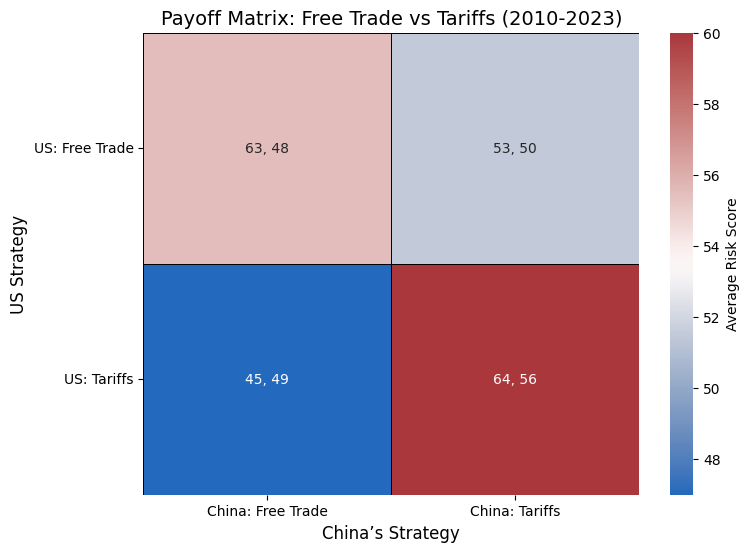

In [ ]:
# Define the intervals for each scenario
intervals = {
    # Both Cooperate
    ('Free Trade', 'Free Trade'): ('2010-01-01', '2017-12-31'),
    # Both Defect
    ('Tariffs', 'Tariffs'): ('2018-03-22', '2023-12-31'),
    # China defects, USA cooperates
    ('Free Trade', 'Tariffs'): ('2019-08-01', '2020-02-01'),
    # USA defects, China cooperates
    ('Tariffs', 'Free Trade'): ('2017-09-30 ', '2019-09-30')
}

# Define the countries
countries = ['USA', 'China']

# Calculate risk scores for each scenario and round them
risk_scores = {}

for (us_policy, china_policy), interval in intervals.items():
    start_date, end_date = interval
    for country in countries:
        risk_score, _ = calc_risk_score(df, country, start_date, end_date)
        risk_scores[(us_policy, china_policy, country)] = round(risk_score)  # Rounded

# Create the Payoff Matrix as a DataFrame with tuples
payoff_matrix = pd.DataFrame({
    'China: Free Trade': [
        (risk_scores[('Free Trade', 'Free Trade', 'USA')], risk_scores[('Free Trade', 'Free Trade', 'China')]),
        (risk_scores[('Tariffs', 'Free Trade', 'USA')], risk_scores[('Tariffs', 'Free Trade', 'China')])
    ],
    'China: Tariffs': [
        (risk_scores[('Free Trade', 'Tariffs', 'USA')], risk_scores[('Free Trade', 'Tariffs', 'China')]),
        (risk_scores[('Tariffs', 'Tariffs', 'USA')], risk_scores[('Tariffs', 'Tariffs', 'China')])
    ]
}, index=['US: Free Trade', 'US: Tariffs'])

# Print the Payoff Matrix
print("Payoff Matrix:")
print(payoff_matrix)

# Convert the matrix to a string format for heatmap annotation
payoff_matrix_str = payoff_matrix.applymap(lambda x: f"{x[0]}, {x[1]}")

# Convert the matrix into a numerical form for coloring
heatmap_values = payoff_matrix.applymap(lambda x: (x[0] + x[1]) / 2)  # Average of USA & China scores

# Create a heatmap with better color distribution
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_values, annot=payoff_matrix_str, fmt="",
    cmap="vlag",  # Improved colormap for distinct colors
    linewidths=0.5, linecolor='black',
    cbar_kws={'label': 'Average Risk Score'}
)

# Add title and labels
plt.title('Payoff Matrix: Free Trade vs Tariffs (2010-2023)', fontsize=14)
plt.xlabel('China’s Strategy', fontsize=12)
plt.ylabel('US Strategy', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.show()

In [ ]:
print(df[(df['Country'] == 'China')])


          Date Country  Inflation Rate (%)  GDP Growth Rate (%)  \
10  2010-04-30   China                8.68                 5.86   
21  2010-08-31   China                0.62                 9.61   
30  2010-12-31   China                9.59                 9.11   
31  2010-12-31   China                1.61                 0.57   
51  2011-08-31   China                8.94                 0.74   
55  2011-09-30   China                1.39                 9.66   
61  2011-11-30   China                9.10                -2.33   
64  2011-12-31   China                5.34                 1.99   
73  2012-03-31   China                0.45                 3.03   
95  2012-11-30   China                6.33                 9.23   
104 2013-02-28   China                8.40                 4.38   
111 2013-04-30   China                5.87                 9.88   
120 2013-08-31   China                1.32                 0.14   
161 2014-07-31   China                7.44                 5.8

## Cluster Analysis + PCA

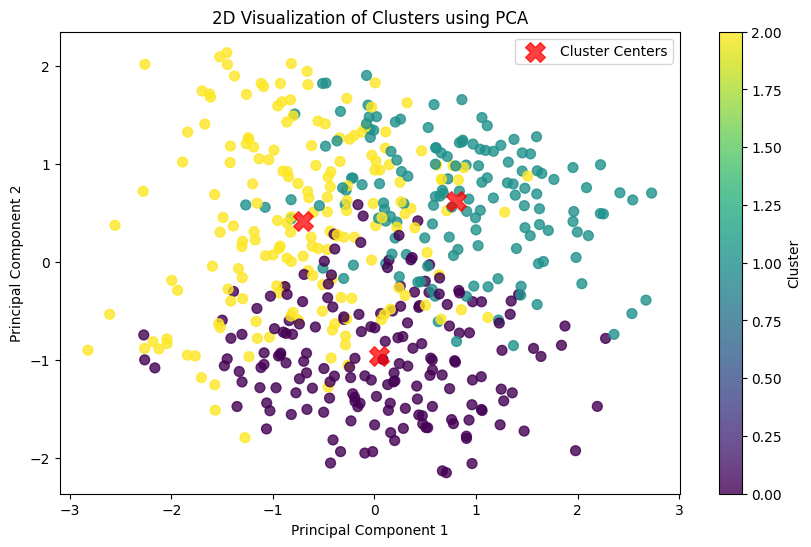

Cluster Summary:
         Inflation Rate (%)  GDP Growth Rate (%)  Unemployment Rate (%)  \
Cluster                                                                   
0                  2.156914             2.459657               7.617429   
1                  7.542945             3.093699               6.778082   
2                  5.943240             1.817151               6.316816   

         Interest Rate (%)  
Cluster                     
0                 5.689143  
1                 7.505753  
2                 1.439385  


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preprocessing the data
# Select numerical features for clustering - omitting stock bc it's dominating other features
numerical_features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)']
df_numerical = df[numerical_features]

# Normalize the numerical features
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_numerical)

# PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_normalized)

# K-Means w/ 3 clusters
n_clusters = 3 # to do: iterate through + elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(df_normalized)

# Visualize the clusters w/ our friend PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)

# Add cluster centers
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Cluster Centers')

# Labels 'n title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Clusters using PCA')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

df['Cluster'] = clusters

# Debug: mean values of each feature for each cluster
cluster_summary = df.groupby('Cluster')[numerical_features].mean()
print("Cluster Summary:")
print(cluster_summary)